In [44]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from utils.clustering import MakeCluster

In [45]:
df = pd.read_csv('merged_data.csv')
df['deposit_by_area'] = df['deposit'] / df['area_m2']
print(len(df))
df.head(2)

1867783


,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,...,total_large_park_area_10km,nearest_subway_distance_km,school_count_within_1km,closest_elementary_distance,closest_middle_distance,closest_high_distance,deposit_mean,interest_rate,interest_rate_diff,deposit_by_area
0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0,...,3082215.1,0.716953,4,0.15612,0.465125,0.990855,31188.259433,1.92,-0.07,200.004471
1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0,...,3082215.1,0.716953,4,0.15612,0.465125,0.990855,32309.834287,1.63,0.08,270.594284


# 1. 위도 경도 기준 DBSCAN -> 외곽 지역인가? 아닌가?

In [46]:
# train data에 대한 아파트 개수 구하기
apartment = df[df['contract_year_month'] < 202401][['latitude', 'longitude']].drop_duplicates().reset_index(drop=True)
print(len(apartment))
apartment.head(2)

18491


,latitude,longitude
0,37.054314,127.045216
1,36.964647,127.055847


In [47]:
scaler = StandardScaler()
apartment_scaled = scaler.fit_transform(apartment)
apartment_scaled_df = pd.DataFrame(apartment_scaled, columns=['latitude', 'longitude'])


In [48]:
make_cluster = MakeCluster()


Change point at index 18484, distance: 0.4152021669639914
Change point at index 18487, distance: 0.5381801681808399
Change point at index 18489, distance: 0.7619992808290209


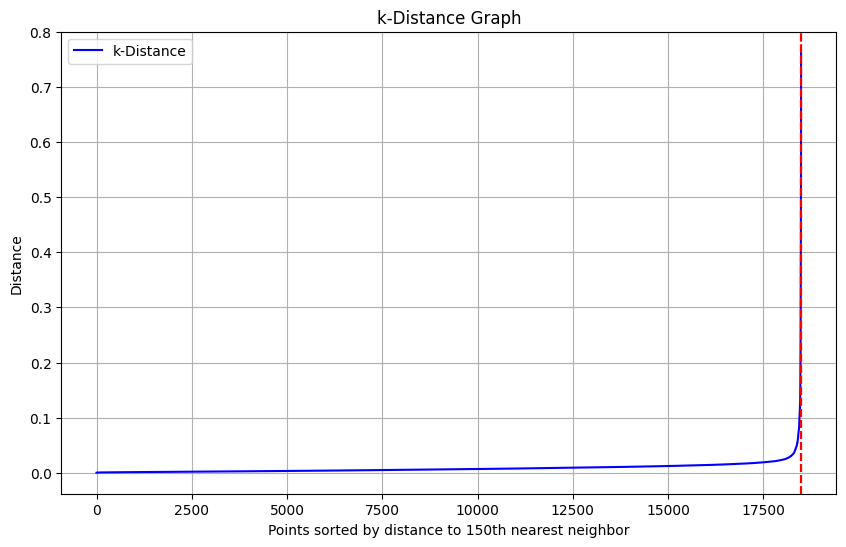

[0.4152021669639914, 0.5381801681808399, 0.7619992808290209]

In [68]:
make_cluster.find_eps(apartment_scaled_df,k =150, threshold=0.05,visualize=True)


In [50]:
make_cluster.check_silhouette_score(apartment_scaled_df,min_samples=150)
# 50 100 150 200 중 150의 실루엣 점수가 가장 높음

Silhouette Score: 0.5118


In [51]:
df_cluster = make_cluster.apply_dbscan(apartment_scaled_df,min_samples=150)
df_cluster.head(3)

,latitude,longitude,cluster_0
0,-2.945573,0.519665,0
1,-3.551297,0.582879,0
2,-3.498991,0.753341,0


/data/ephemeral/home/utils/clustering.py:78: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(data.loc[df[col] == label, data.columns[1]],


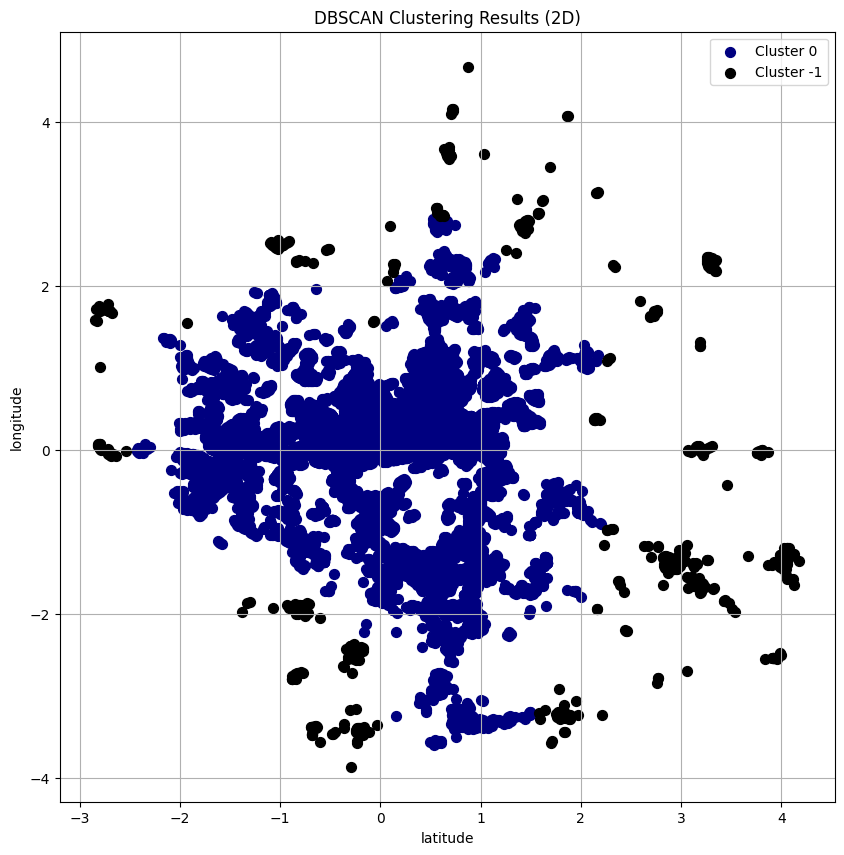

In [52]:
make_cluster.visualize_result(df_cluster)

In [53]:
df_cluster

,latitude,longitude,cluster_0
0,-2.945573,0.519665,0
1,-3.551297,0.582879,0
2,-3.498991,0.753341,0
3,-3.546052,0.540850,0
4,-3.602356,0.532939,0
...,...,...,...
18486,0.825824,-1.783611,0
18487,0.633383,-1.434675,0
18488,0.623088,-1.436796,0
18489,0.614095,-1.495806,0


In [54]:
apartment_cluster = apartment.copy()
apartment_cluster['outside'] = df_cluster['cluster_0']

In [58]:
merged_df = pd.merge(df, apartment_cluster[['latitude', 'longitude', 'outside']],
                     on=['latitude', 'longitude'],
                     how='left')


In [62]:
merged_df[merged_df['contract_year_month']<202401][['outside','deposit_by_area','deposit']]

,outside,deposit_by_area,deposit
0,0.0,200.004471,17000.0
1,0.0,270.594284,23000.0
2,0.0,270.594284,23000.0
3,0.0,84.260195,5000.0
4,0.0,30.095302,1800.0
...,...,...,...
1717606,0.0,339.683972,39000.0
1717607,0.0,372.882420,38000.0
1717608,0.0,322.327729,37000.0
1717609,0.0,337.556717,34400.0


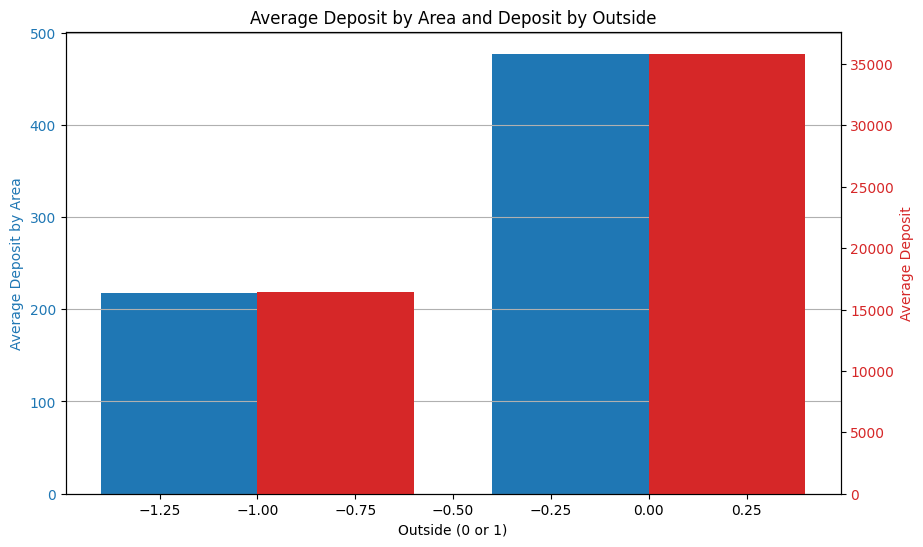

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# 평균 계산
mean_values = merged_df.groupby('outside').agg(
    mean_deposit_by_area=('deposit_by_area', 'mean'),
    mean_deposit=('deposit', 'mean')
).reset_index()

# 바 그래프 시각화
fig, ax1 = plt.subplots(figsize=(10, 6))

# 첫 번째 축: deposit_by_area
color = 'tab:blue'
ax1.set_xlabel('Outside (0 or 1)')
ax1.set_ylabel('Average Deposit by Area', color=color)
ax1.bar(mean_values['outside'] - 0.2, mean_values['mean_deposit_by_area'], width=0.4, color=color, label='Deposit by Area')
ax1.tick_params(axis='y', labelcolor=color)

# 두 번째 축: deposit
ax2 = ax1.twinx()  # 두 번째 축 생성
color = 'tab:red'
ax2.set_ylabel('Average Deposit', color=color)
ax2.bar(mean_values['outside'] + 0.2, mean_values['mean_deposit'], width=0.4, color=color, label='Deposit')
ax2.tick_params(axis='y', labelcolor=color)

# 타이틀 및 그리드 설정
plt.title('Average Deposit by Area and Deposit by Outside')
ax1.grid(axis='y')
plt.show()


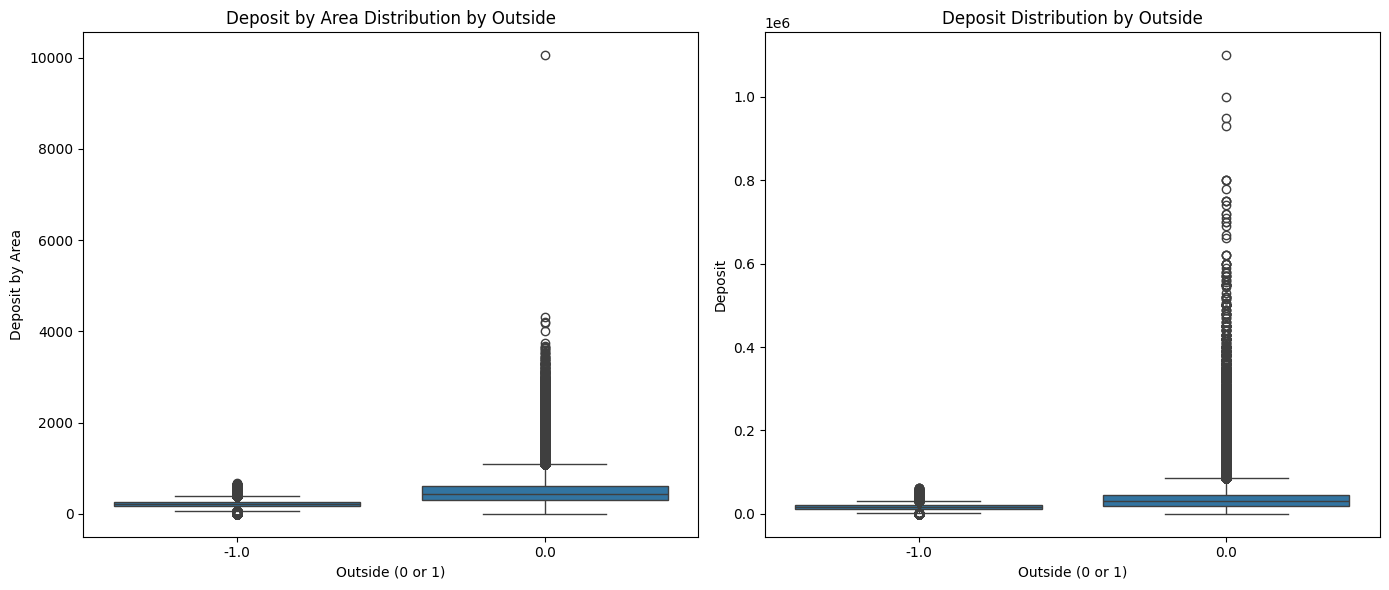

In [64]:
plt.figure(figsize=(14, 6))

# deposit_by_area 상자 수염 그래프
plt.subplot(1, 2, 1)
sns.boxplot(x='outside', y='deposit_by_area', data=merged_df)
plt.title('Deposit by Area Distribution by Outside')
plt.xlabel('Outside (0 or 1)')
plt.ylabel('Deposit by Area')

# deposit 상자 수염 그래프
plt.subplot(1, 2, 2)
sns.boxplot(x='outside', y='deposit', data=merged_df)
plt.title('Deposit Distribution by Outside')
plt.xlabel('Outside (0 or 1)')
plt.ylabel('Deposit')

plt.tight_layout()
plt.show()


# 2. 여러 변수를 함께 넣어서 군집화 해보기
지피티 추천
1. 위치와 접근성 기반 군집화:
- 변수: latitude, longitude, nearest_park_distance, nearest_subway_distance_km
- 목표: 주거지의 위치에 따라 군집화하여 인프라에 대한 접근성을 파악
2. 물리적 특성 및 재정적 측면 군집화:
- 변수: area_m2, floor, built_year, deposit, deposit_by_area
- 목표: 아파트의 물리적 특성과 보증금에 따라 시장 세분화
3. 환경 및 인프라 기반 군집화:
- 변수: school_count_within_1km, park_count_500m, total_large_park_area_10km
- 목표: 주변 환경의 질에 따른 군집화


## (1) 위치와 접근성 기반 군집화